# Logical shadow tomography: $[[5, 1, 3]]$ code example

## Setup

In [1]:
import functools
from joblib import Parallel, delayed
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from tqdm.notebook import tnrange

import qutip

from base.stabilizer import random_clifford_state, stabilizer_state, StabilizerState, stoc_depolarize_map
from base.utils import stabilizer_projection_full
from convert import sample_from_mean, state2state as stabilizer_state_to_qutip_qobj, state2paulis, state2projector

In [2]:
plt.rcParams.update({"font.family": "serif", "font.size": 16})

## Parameters

In [3]:
"""Set experimental parameters."""
num_trajectories: int = 40_000  # Number of trajectories to sample from.

simulator: str = "trajectory"  # (Classical) simulator to use to draw samples. Options are "density_matrix" and "trajectory".
    
use_rho: bool = True           # Do LST with rho.
use_rho_squared: bool = False  # Do LST with rho^2.

pmin: float = 0.00  # Minimum depolarizing noise rate.
pmax: float = 0.50  # Maximum depolarizing noise rate.
step: float = 0.10  # Step for depolarizing noise rates. Values are `np.arange(pmin, pmax + step, step)`.

njobs: int = 2  # Number of parallel workers to use when sampling trajectories.

In [4]:
pvalues = np.arange(pmin, pmax + step, step)
N: int = 5
D: int = 2**N + 1

## Collect shadows

### Quantum trajectory simulator

In [5]:
def sample_trajectory(p: float) -> "StabilizerState":
    # Start in the logical subspace.
    state = stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")

    # Apply single-qubit depolarizing noise.
    state = stoc_depolarize_map(state, p)

    # Apply a random clifford.
    state.measure(random_clifford_state(N))
    return state

### Density matrix simulator

In [6]:
from ncon import ncon

def generate_loc_mixer(px: float, py: float, pz: float) -> np.ndarray:
    # Tensor network calculation of depolarization channel
    p = px+py+pz
    I = np.array([[1, 0],[0, 1]]);
    X = np.array([[0, 1],[1, 0]]);    s1 = X;
    Z = np.array([[1, 0],[0, -1]]);   s3 = Z;
    Y = np.array([[0, -1j],[1j, 0]]); s2 = Y;

    USA=np.zeros((2,2,4,4));

    E00 = np.zeros((4,4));
    E10 = np.zeros((4,4));
    E20 = np.zeros((4,4));
    E30 = np.zeros((4,4));
    E00[0,0] = 1;
    E10[1,0] = 1;
    E20[2,0] = 1;
    E30[3,0] = 1;

    USA = USA + np.sqrt(1.0-p)*ncon((I,E00),([-1,-2],[-3,-4]))
    USA = USA + np.sqrt(px)*ncon((s1,E10),([-1,-2],[-3,-4]))
    USA = USA + np.sqrt(py)*ncon((s2,E20),([-1,-2],[-3,-4]))
    USA = USA + np.sqrt(pz)*ncon((s3,E30),([-1,-2],[-3,-4]))

    E0=np.zeros((4));
    E0[0] = 1;
    loc_mixer = ncon( ( USA,E0, np.conj(USA), E0 ),([-1,-2,1,3],[3],[-4,-3,1,2],[2]));
    return loc_mixer

In [7]:
def DensityMatrix_Measure(rho_ori: qutip.Qobj, ops, N) -> "StabilizerState":
    rho = rho_ori.copy()
    gs = ops.gs.copy()
    ps = ops.ps.copy()
    ID = qutip.tensor([qutip.qeye(2) for i in range(N)])

    pauli_list = state2paulis(ops)
    for i in range(len(pauli_list)):
        tmp_mean = np.trace(rho*pauli_list[i])
        readout = sample_from_mean(tmp_mean.real)#+/- 1
        readout_p = 1-readout
        ps[i] = (ps[i]+readout_p)%4
        proj = (ID+readout*pauli_list[i])/2
        rho = (proj*rho*proj).unit()
    return StabilizerState(gs, ps)

In [8]:
def get_noisy_state(p: float) -> qutip.Qobj:
    rho0 = stabilizer_state_to_qutip_qobj(stabilizer_state('XZZXI','IXZZX','XIXZZ','ZXIXZ','ZZZZZ'))
    rho_tensor = rho0.full().reshape([2 for i in range(10)])

    px = py = pz = p / 3.0
    locMixer = generate_loc_mixer(px,py,pz)

    index = []
    index.append([i for i in range(1,11)])
    for i in range(5):
        index.append([i+1,-(i+1),-(i+1+5),i+1+5])
    eps_rho = ncon([rho_tensor]+[locMixer for i in range(5)],index)
    eps_rho=eps_rho.reshape(2**N, 2**N)

    return qutip.Qobj(eps_rho,dims=[[2 for i in range(N)],[2 for i in range(N)]])

In [9]:
def sample_density_matrix(rho: qutip.Qobj) -> "StabilizerState":
    return DensityMatrix_Measure(rho, random_clifford_state(N), N)

In [10]:
%timeit get_noisy_state(0.1)

8.63 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
rho = get_noisy_state(0.1)

In [12]:
%timeit sample_density_matrix(rho)

14.5 ms ± 4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit sample_trajectory(0.1)

507 µs ± 174 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Run simulator

In [14]:
simulators = ("density_matrix", "trajectory")

if simulator not in simulators:
    raise ValueError(f"Unknown simulator option. Expected one of {simulators} but got {simulator}.")

sampler = sample_density_matrix if simulator == "density_matrix" else sample_trajectory

In [15]:
all_shadows = []
for i in tnrange(len(pvalues), desc=f"Sampling {num_trajectories} shadows from {len(pvalues)} noise levels"):
    if simulator == "density_matrix":
        
        rho = get_noisy_state(pvalues[i])
        shadows = Parallel(n_jobs=njobs)(
            delayed(sample_density_matrix)(rho) for _ in range(num_trajectories)
        )
    else:
        
        shadows = Parallel(n_jobs=njobs)(
            delayed(sample_trajectory)(pvalues[i]) for _ in range(num_trajectories)
        )
    all_shadows.append(shadows)

Sampling 40000 shadows from 6 noise levels:   0%|          | 0/6 [00:00<?, ?it/s]

## Postprocess

### Convert all shadows to density matrices

In [16]:
def inverse_map(sigma: np.array) -> np.array:
    d = len(sigma)
    return (d + 1) * sigma - np.identity(d)

In [17]:
all_sigmas = []

for i in tnrange(len(all_shadows), desc="Converting all shadows to density matrices"):
    shadows = all_shadows[i]
    sigmas = []
    for j in tnrange(len(shadows), desc=f"Converting shadows to density matrices for noise level p = {pvalues[i]:.3f}", leave=False):
        sigmas.append(inverse_map(stabilizer_state_to_qutip_qobj(shadows[j]).full()))
    all_sigmas.append(sigmas)

Converting all shadows to density matrices:   0%|          | 0/6 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.000:   0%|          | 0/40000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.100:   0%|          | 0/40000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.200:   0%|          | 0/40000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.300:   0%|          | 0/40000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.400:   0%|          | 0/40000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.500:   0%|          | 0/40000 [00:00<?, ?it/s]

In [18]:
"""Projector P."""
state = stabilizer_state("XZZXI", "IXZZX", "XIXZZ", "ZXIXZ", "ZZZZZ")
state.r = 1
projector = functools.reduce(lambda a, b: a * b, state2projector(state))
projector = projector.full()

In [19]:
"""Tests."""
assert np.allclose(projector @ projector, projector)
assert np.allclose(projector.conj().T, projector)

In [20]:
"""Observable O."""
obs = stabilizer_state_to_qutip_qobj(
    stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")
)

# Tests.
evals = np.zeros(2 ** N)
evals[-1] = 1
assert np.allclose(obs.eigenenergies(), evals)

obs = obs.full()

### LST with $\rho$

In [21]:
def sigma_to_numerator_and_denominator(sigma: "StabilizerState") -> Tuple[float, float]:
    """Returns Tr[M^-1 (shadow) P O], Tr[M^-1 (shadow) P]."""
    projected = sigma @ projector
    return np.trace(projected @ obs), np.trace(projected)

In [22]:
if use_rho:
    lst_fidelities = []
    for i in tnrange(len(all_sigmas), desc="Estimating all fidelities with ρ"):
        sigmas = all_sigmas[i]
        numerator = 0.0
        denominator = 0.0
        for j in tnrange(len(sigmas), desc=f"Estimating fidelity with {len(sigmas)} shadows for noise level p = {pvalues[i]:.3f}", leave=False):
            num, denom = sigma_to_numerator_and_denominator(sigmas[j])
            numerator += num
            denominator += denom

        lst_fidelities.append(numerator / denominator)
    
    lst_fidelities = np.array(lst_fidelities)

Estimating all fidelities with ρ:   0%|          | 0/6 [00:00<?, ?it/s]

Estimating fidelity with 40000 shadows for noise level p = 0.000:   0%|          | 0/40000 [00:00<?, ?it/s]

Estimating fidelity with 40000 shadows for noise level p = 0.100:   0%|          | 0/40000 [00:00<?, ?it/s]

Estimating fidelity with 40000 shadows for noise level p = 0.200:   0%|          | 0/40000 [00:00<?, ?it/s]

Estimating fidelity with 40000 shadows for noise level p = 0.300:   0%|          | 0/40000 [00:00<?, ?it/s]

Estimating fidelity with 40000 shadows for noise level p = 0.400:   0%|          | 0/40000 [00:00<?, ?it/s]

Estimating fidelity with 40000 shadows for noise level p = 0.500:   0%|          | 0/40000 [00:00<?, ?it/s]

### LST with $\rho^2$

In [23]:
def sigmas_to_numerator_and_denominator(
    sigma1: np.ndarray, sigma2: np.ndarray
) -> Tuple[float, float]:
    """Returns Tr[M^-1 (shadow1) M^-1(shadow2) P O], Tr[M^-1 (shadow1) M^-1(shadow2) P].
    """
    projected = sigma1 @ sigma2 @ projector
    return np.trace(projected @ obs), np.trace(projected)

In [24]:
if use_rho_squared:
    lst_vd_fidelities = []
    for i in tnrange(len(all_sigmas), desc="Estimating all fidelities with ρ^2"):
        sigmas = all_sigmas[i]
        numerator = 0.0
        denominator = 0.0
        for j in tnrange(len(sigmas), desc=f"Estimating fidelity with {len(sigmas)} shadows for noise level p = {pvalues[i]:.3f}", leave=False):
            for k in range(len(sigmas)):
                if k == j:
                    continue
                num, denom = sigmas_to_numerator_and_denominator(sigmas[j], sigmas[k])
                numerator += num
                denominator += denom

        lst_vd_fidelities.append(num / denom)
    
    lst_vd_fidelities = np.array(lst_vd_fidelities)

In [25]:
def analytic_fidelity(p):
    N = (8 * p ** 2 - 9 * p + 3) * (2 * p - 3) ** 3
    D = 240 * p ** 4 - 720 * p ** 3 + 810 * p ** 2 - 405 * p + 81
    return -N / D

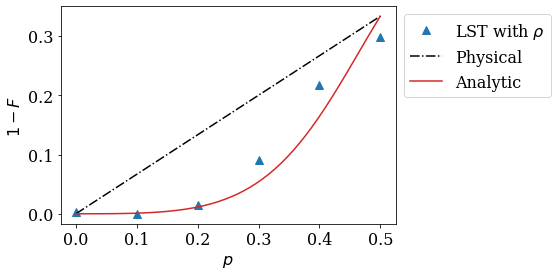

In [26]:
if use_rho:
    plt.plot(pvalues, 1.0 - lst_fidelities.real, "^", markersize=8, label=r"LST with $\rho$")

if use_rho_squared:
    plt.plot(pvalues, 1 - lst_vd_fidelities.real, "*", markersize=8, label=r"LST with $\rho^2$")


plt.plot(pvalues, 2 * pvalues / 3, "-.", c="k", label="Physical")
plt.plot(
    np.linspace(0, 0.5, 50), 1 - analytic_fidelity(np.linspace(0, 0.5, 50)), c="C3", label="Analytic"
)

# Plot options.
plt.xlabel("$p$")
plt.ylabel("$1 - F$")
plt.legend(bbox_to_anchor=(1, 1));